<a href="https://colab.research.google.com/github/subash-0/3s-libray/blob/main/Copy_of_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# prompt: extract the following /content/archive.zip

# !unzip '/content/drive/MyDrive/Colab Notebooks/Untitled folder/archive.zip'


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Imports
import os

import torch
import torchvision
from torchvision.io import read_image
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
import torch.optim as optim
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm

In [ ]:
# Data

MANUAL_SEED = 42
BATCH_SIZE = 32
SHUFFLE = True

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.io import read_image

# Set constants
BATCH_SIZE = 32
SHUFFLE = True
MANUAL_SEED = 42  # Ensure reproducibility

# Define Dataset Class
class LandscapeDataset(Dataset):
    def __init__(self, transform=None):
        self.dataroot = '/content/sample_data/landscape Images'
        self.images = os.listdir(f'{self.dataroot}/color')
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]

        # Load images
        color_img = read_image(f'{self.dataroot}/color/{img_path}').float() / 255.0
        gray_img = read_image(f'{self.dataroot}/gray/{img_path}').float() / 255.0

        # Ensure correct dimensions (Gray: 1xHxW, Color: 3xHxW)
        if gray_img.shape[0] == 3:  # Convert RGB to Grayscale if needed
            gray_img = transforms.Grayscale()(gray_img)

        # Apply transformations (same for both images)
        if self.transform:
            color_img = self.transform(color_img)
            gray_img = self.transform(gray_img)

        return gray_img, color_img  # Return grayscale as input, color as target

# Define Transformations
transform = transforms.Compose([
    transforms.Resize((150, 150), antialias=True),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to range [-1, 1]
])

# Load Dataset
dataset = LandscapeDataset(transform=transform)

# Split Dataset
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(MANUAL_SEED))

# Data Loaders
trainloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
testloader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

# Print sample batch shape for verification
gray_sample, color_sample = next(iter(trainloader))
print(f"Gray Image Shape: {gray_sample.shape}, Color Image Shape: {color_sample.shape}")


FileNotFoundError: [Errno 2] No such file or directory: '/content/sample_data/landscape Images/color'

In [ ]:
# Visualize some images
def show_images(color, gray):
    fig, axs = plt.subplots(5, 2, figsize=(15, 15))
    axs[0, 0].set_title('Grayscale')
    axs[0, 1].set_title('Color')
    for i in range(5):
        axs[i, 0].imshow(gray[i].permute(1,2,0), cmap='gray')
        axs[i, 0].axis('off')
        axs[i, 1].imshow(color[i].permute(1,2,0))
        axs[i, 1].axis('off')
    plt.show()

In [ ]:
color, gray = next(iter(trainloader))
show_images(color, gray)

In [ ]:
# Training Variables


DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# # Create the autoencoder model
# class ColorAutoEncoder(nn.Module):
#     def __init__(self):
#         super().__init__()
#         # Input shape: Bx1x150x150
#         # Conv2d(in_channels, out_channels, kernel_size, stride, padding)


#         self.downsample = nn.Sequential(
#             nn.Conv2d(1, 64, 3, stride=2), # Bx64x74x74
#             nn.ReLU(),

#             nn.Conv2d(64, 128, 3, stride=2), # Bx128x36x36
#             nn.ReLU(),

#             nn.Conv2d(128, 256, 3, stride=2), # Bx256x17x17
#             nn.ReLU(),

#             nn.Conv2d(256, 512, 3, stride=2), # Bx512x8x8
#             nn.ReLU(),
#         )

#         self.upsample = nn.Sequential(
#             nn.ConvTranspose2d(512, 256, 3, stride=2),
#             nn.ReLU(),

#             nn.ConvTranspose2d(256, 128, 3, stride=2,  output_padding=1),
#             nn.ReLU(),

#             nn.ConvTranspose2d(128, 64, 3, stride=2, output_padding=1),
#             nn.ReLU(),

#             nn.ConvTranspose2d(64, 3, 3, stride=2, output_padding=1),
#             nn.ReLU(),

#         )

#     def forward(self, x):
#         x = self.downsample(x)
#         x = self.upsample(x)
#         return x

In [ ]:
import torch
import torch.nn as nn

class ColorAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoding (Downsampling)
        self.down1 = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=2, padding=1),  # Bx64x75x75
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2)
        )
        self.down2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, stride=2, padding=1),  # Bx128x38x38
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2)
        )
        self.down3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, stride=2, padding=1),  # Bx256x19x19
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.down4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, stride=2, padding=1),  # Bx512x10x10
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )

        # Decoding (Upsampling)
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1, output_padding=1),  # Bx256x19x19
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2)
        )
        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(512, 128, 3, stride=2, padding=1, output_padding=1),  # Bx128x38x38
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2)
        )
        self.up3 = nn.Sequential(
            nn.ConvTranspose2d(256, 64, 3, stride=2, padding=1, output_padding=1),  # Bx64x75x75
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2)
        )
        self.up4 = nn.Sequential(
            nn.ConvTranspose2d(128, 3, 3, stride=2, padding=1, output_padding=1),  # Bx3x150x150
            nn.Tanh()
        )

    def forward(self, x):
        # Encoding path
        d1 = self.down1(x)  # 64x75x75
        d2 = self.down2(d1)  # 128x38x38
        d3 = self.down3(d2)  # 256x19x19
        d4 = self.down4(d3)  # 512x10x10

        # Decoding path
        u1 = self.up1(d4)  # 256x19x19
        u1 = nn.functional.interpolate(u1, size=d3.shape[2:], mode="bilinear", align_corners=False)  # Match d3 size

        u2 = self.up2(torch.cat((u1, d3), dim=1))  # 128x38x38
        u2 = nn.functional.interpolate(u2, size=d2.shape[2:], mode="bilinear", align_corners=False)  # Match d2 size

        u3 = self.up3(torch.cat((u2, d2), dim=1))  # 64x75x75
        u3 = nn.functional.interpolate(u3, size=d1.shape[2:], mode="bilinear", align_corners=False)  # Match d1 size

        u4 = self.up4(torch.cat((u3, d1), dim=1))  # 3x150x150

        return u4


In [ ]:
# Initialize the model
model = ColorAutoEncoder().to(DEVICE)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
f"Total Number of trainable parameters of this model are: {total_params:,}"

'Total Number of trainable parameters of this model are: 3,473,475'

In [ ]:
EPOCHS = 20
LEARNING_RATE = 0.001
MOMENTUM = 0.9

# Initialize the optimizer and loss function
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
# Define the training loop
trainLoss = []
testLoss = []
for epoch in range(EPOCHS):
    running_loss = 0.0
    running_test_loss = 0.0
    for idx, (color_img, gray_img) in tqdm(enumerate(trainloader), total=len(trainloader)):
        color_img = color_img.to(DEVICE)
        gray_img = gray_img.to(DEVICE)

        # Make model predictions
        predictions = model(gray_img)

        optimizer.zero_grad()
        # Calculate loss between coloured image and predicted image
        loss = criterion(color_img, predictions)

        # Calcuate gradients and back propagate
        loss.backward()
        optimizer.step()

        running_loss += loss.item()



    trainLoss.append(running_loss/len(trainloader))
    with torch.no_grad():
            for idx, (color_img, gray_img) in tqdm(enumerate(testloader), total=len(testloader)):
              gray_img = gray_img.to(DEVICE)
              color_img = color_img.to(DEVICE)

              prediction = model(gray_img)

              loss = criterion(prediction, color_img)
              running_test_loss += loss.item()
    testLoss.append(running_test_loss/len(testloader))
    print(f'[{epoch}/{EPOCHS}] Train Loss = {running_loss}, Test Loss= {running_test_loss}')





print('Training Finished!')




  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[0/20] Train Loss = 6.988041317090392, Test Loss= 0.8038889821618795


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[1/20] Train Loss = 2.3036310742609203, Test Loss= 0.4608705504797399


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[2/20] Train Loss = 1.5930072460323572, Test Loss= 0.36855528177693486


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[3/20] Train Loss = 1.36251687631011, Test Loss= 0.3415759215131402


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[4/20] Train Loss = 1.3087506447918713, Test Loss= 0.3596885115839541


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[5/20] Train Loss = 1.267864862922579, Test Loss= 0.3274212898686528


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[6/20] Train Loss = 1.2238135123625398, Test Loss= 0.3195177768357098


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[7/20] Train Loss = 1.2322809933684766, Test Loss= 0.31723766727373004


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[8/20] Train Loss = 1.185509504750371, Test Loss= 0.3196300067938864


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[9/20] Train Loss = 1.1897285738959908, Test Loss= 0.3282900620251894


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[10/20] Train Loss = 1.2018315233290195, Test Loss= 0.3174395468086004


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[11/20] Train Loss = 1.173385040834546, Test Loss= 0.3101282576099038


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[12/20] Train Loss = 1.1711578639224172, Test Loss= 0.2977065369486809


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[13/20] Train Loss = 1.1393193202093244, Test Loss= 0.2998266408685595


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[14/20] Train Loss = 1.1465372857637703, Test Loss= 0.31977799255400896


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[15/20] Train Loss = 1.148620129097253, Test Loss= 0.3082461627200246


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[16/20] Train Loss = 1.1467362474650145, Test Loss= 0.29602025356143713


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[17/20] Train Loss = 1.1264158247504383, Test Loss= 0.29241308686323464


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[18/20] Train Loss = 1.1387888337485492, Test Loss= 0.31605857284739614


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

[19/20] Train Loss = 1.1238230434246361, Test Loss= 0.29334453446790576
Training Finished!


In [ ]:
# Test on testing data
total_loss = 0.0
with torch.no_grad():
    for idx, (color_img, gray_img) in tqdm(enumerate(testloader), total=len(testloader)):
        color_img = color_img.to(DEVICE)
        gray_img = gray_img.to(DEVICE)

        prediction = model(gray_img)

        loss = criterion(prediction, color_img)
        total_loss += loss.item()

f"Total Testing loss is: {total_loss/ len(testloader):.3f}"

  0%|          | 0/45 [00:00<?, ?it/s]

'Total Testing loss is: 0.007'

In [ ]:
# Visualize some predictions
def show_predictions(color, gray, pred):
    fig, axs = plt.subplots(5, 3, figsize=(15, 15))
    axs[0, 0].set_title('Grayscale')
    axs[0, 1].set_title('Color')
    axs[0, 2].set_title('Predicted')
    for i in range(5):
        axs[i, 0].axis('off')
        axs[i, 0].imshow(gray[i].permute(1,2,0), cmap='gray')
        axs[i, 1].axis('off')
        axs[i, 1].imshow(color[i].permute(1,2,0))
        axs[i, 2].axis('off')
        axs[i, 2].imshow(pred[i].permute(1,2,0))
    plt.show()


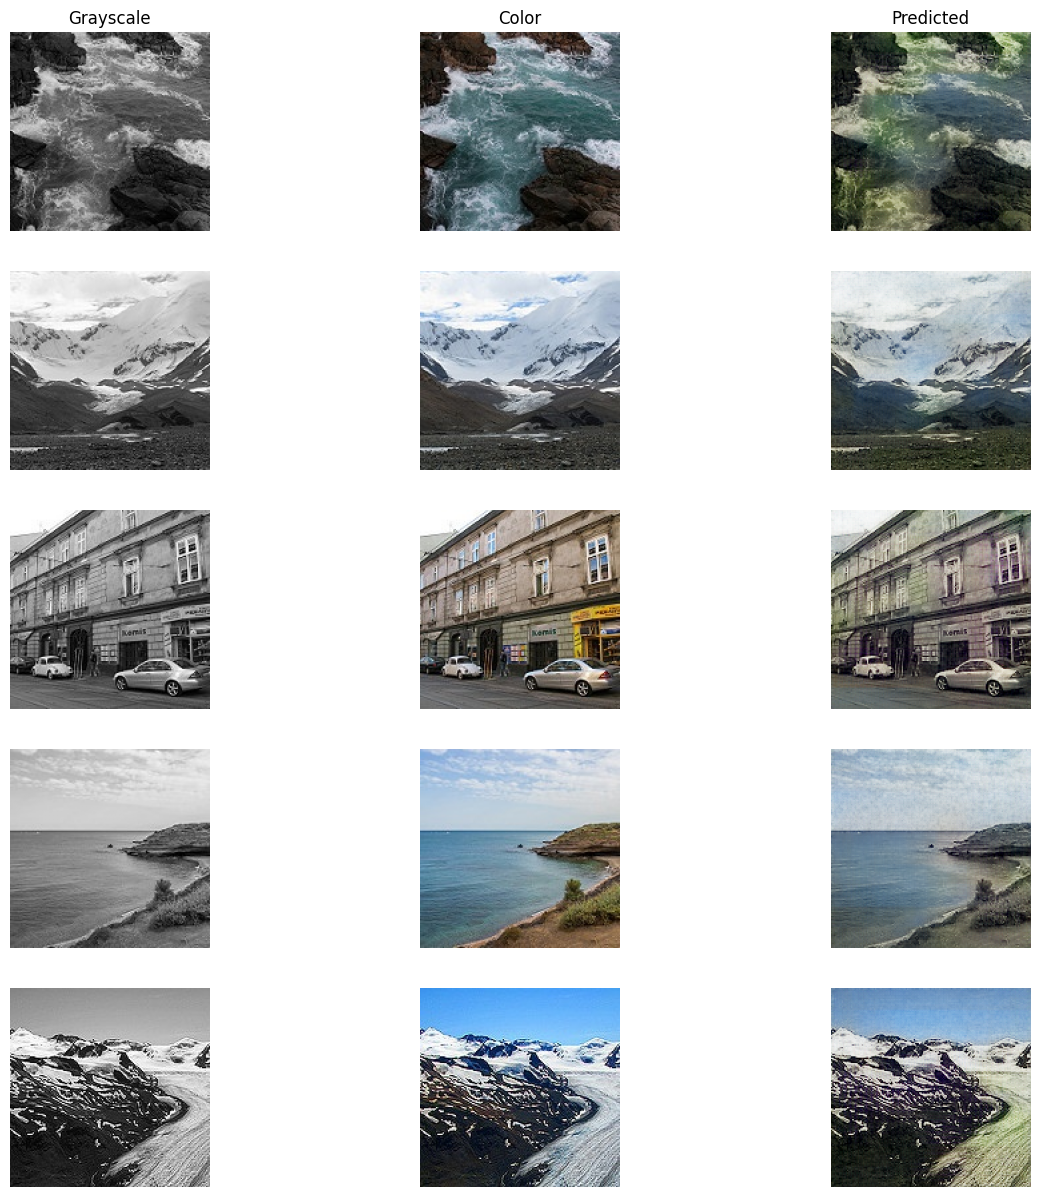

In [ ]:
show_predictions(color_img.detach().cpu(), gray_img.detach().cpu(), prediction.detach().cpu())

In [ ]:
# ## plot train loss vs test loss

# plt.plot(trainLoss, label='Train Loss')
# plt.plot(testLoss, label='Test Loss')
# plt.legend()
# plt.show()

# trainLoss[:4]


# !pip install optuna

[I 2025-02-07 19:19:35,922] A new study created in memory with name: no-name-0d50f240-8421-4c3a-9644-3333e95f2980


Using device: cuda
Epoch [1/5], Train Loss: 0.0183, Test Loss: 0.0152
Epoch [2/5], Train Loss: 0.0122, Test Loss: 0.0106
Epoch [3/5], Train Loss: 0.0109, Test Loss: 0.0096
Epoch [4/5], Train Loss: 0.0101, Test Loss: 0.0095


[I 2025-02-07 19:21:32,702] Trial 0 finished with value: 0.008204431319609285 and parameters: {'lr': 0.00036378531237543665}. Best is trial 0 with value: 0.008204431319609285.


Epoch [5/5], Train Loss: 0.0096, Test Loss: 0.0082
Epoch [1/5], Train Loss: 0.0221, Test Loss: 0.0149
Epoch [2/5], Train Loss: 0.0144, Test Loss: 0.0120
Epoch [3/5], Train Loss: 0.0135, Test Loss: 0.0119
Epoch [4/5], Train Loss: 0.0122, Test Loss: 0.0115


[I 2025-02-07 19:23:31,145] Trial 1 finished with value: 0.011150830373581912 and parameters: {'lr': 0.0080837416688578}. Best is trial 0 with value: 0.008204431319609285.


Epoch [5/5], Train Loss: 0.0116, Test Loss: 0.0112
Epoch [1/5], Train Loss: 0.0198, Test Loss: 0.0129
Epoch [2/5], Train Loss: 0.0139, Test Loss: 0.0119
Epoch [3/5], Train Loss: 0.0124, Test Loss: 0.0102
Epoch [4/5], Train Loss: 0.0114, Test Loss: 0.0103


[I 2025-02-07 19:25:28,540] Trial 2 finished with value: 0.010445259532166852 and parameters: {'lr': 0.0018228331029096832}. Best is trial 0 with value: 0.008204431319609285.


Epoch [5/5], Train Loss: 0.0106, Test Loss: 0.0104
Epoch [1/5], Train Loss: 0.0172, Test Loss: 0.0126
Epoch [2/5], Train Loss: 0.0127, Test Loss: 0.0105
Epoch [3/5], Train Loss: 0.0113, Test Loss: 0.0093
Epoch [4/5], Train Loss: 0.0104, Test Loss: 0.0103


[I 2025-02-07 19:27:26,345] Trial 3 finished with value: 0.009350195702993207 and parameters: {'lr': 0.0008382214019685758}. Best is trial 0 with value: 0.008204431319609285.


Epoch [5/5], Train Loss: 0.0100, Test Loss: 0.0094
Epoch [1/5], Train Loss: 0.0178, Test Loss: 0.0129
Epoch [2/5], Train Loss: 0.0125, Test Loss: 0.0101
Epoch [3/5], Train Loss: 0.0111, Test Loss: 0.0107
Epoch [4/5], Train Loss: 0.0103, Test Loss: 0.0089


[I 2025-02-07 19:29:23,332] Trial 4 finished with value: 0.008016170199132628 and parameters: {'lr': 0.0006923125752111977}. Best is trial 4 with value: 0.008016170199132628.


Epoch [5/5], Train Loss: 0.0098, Test Loss: 0.0080
Best Learning Rate: 0.0006923125752111977
Epoch [1/10], Train Loss: 0.0175, Test Loss: 0.0122
Epoch [2/10], Train Loss: 0.0123, Test Loss: 0.0106
Epoch [3/10], Train Loss: 0.0110, Test Loss: 0.0106
Epoch [4/10], Train Loss: 0.0103, Test Loss: 0.0087
Epoch [5/10], Train Loss: 0.0098, Test Loss: 0.0089
Epoch [6/10], Train Loss: 0.0093, Test Loss: 0.0097
Epoch [7/10], Train Loss: 0.0090, Test Loss: 0.0075
Epoch [8/10], Train Loss: 0.0087, Test Loss: 0.0078
Epoch [9/10], Train Loss: 0.0085, Test Loss: 0.0080
Epoch [10/10], Train Loss: 0.0083, Test Loss: 0.0073


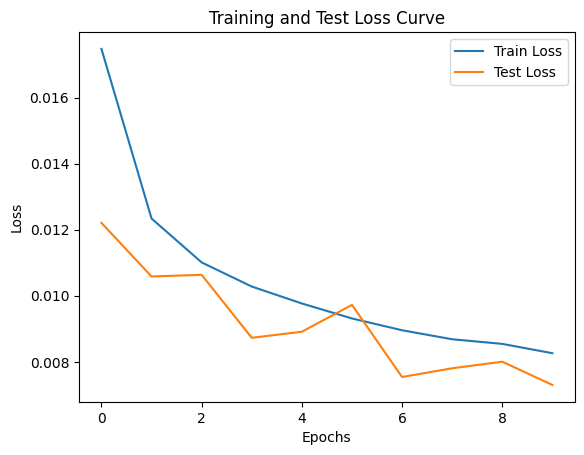

In [ ]:
import os
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.io import read_image
import optuna
import matplotlib.pyplot as plt

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Dataset Class
class LandscapeDataset(Dataset):
    def __init__(self, transform=None):
        self.dataroot = '/content/sample_data/landscape Images'
        self.images = os.listdir(f'{self.dataroot}/color')
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]

        color_img = read_image(f'{self.dataroot}/color/{img_path}').float() / 255.0
        gray_img = read_image(f'{self.dataroot}/gray/{img_path}').float() / 255.0

        if self.transform:
            color_img = self.transform(color_img)
            gray_img = self.transform(gray_img)

        return gray_img, color_img

# Data Transformations
transform = transforms.Compose([
    transforms.Resize((160, 160), antialias=True),
])

# Load Dataset
dataset = LandscapeDataset(transform=transform)

# Split dataset (Fix: Ensure total matches dataset length)
train_size = math.floor(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])

# Loaders
BATCH_SIZE = 16
trainloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

# Autoencoder Model with Batch Normalization
class ColorAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, 3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Training Function
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=5):
    model.train()
    model.to(device)
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        epoch_train_loss = 0
        for gray, color in train_loader:
            gray, color = gray.to(device), color.to(device)

            optimizer.zero_grad()
            outputs = model(gray)
            loss = criterion(outputs, color)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        # Calculate average training loss for the epoch
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Now evaluate on the test set
        model.eval()  # Set the model to evaluation mode
        epoch_test_loss = 0
        with torch.no_grad():
            for gray, color in test_loader:
                gray, color = gray.to(device), color.to(device)
                outputs = model(gray)
                loss = criterion(outputs, color)
                epoch_test_loss += loss.item()

        avg_test_loss = epoch_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

        model.train()  # Set the model back to training mode after evaluation

    return train_losses, test_losses

# Optuna Hyperparameter Tuning
def objective(trial):
    model = ColorAutoEncoder().to(device)
    criterion = nn.MSELoss()
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_loss, test_loss = train_model(model, trainloader, testloader, criterion, optimizer, epochs=5)
    return test_loss[-1]

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)
best_lr = study.best_params['lr']
print(f"Best Learning Rate: {best_lr}")

# Final Training with Best Learning Rate
model = ColorAutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=best_lr)
train_losses, test_losses = train_model(model, trainloader, testloader, criterion, optimizer, epochs=10)

# Plot Training and Test Loss
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Test Loss Curve")
plt.show()


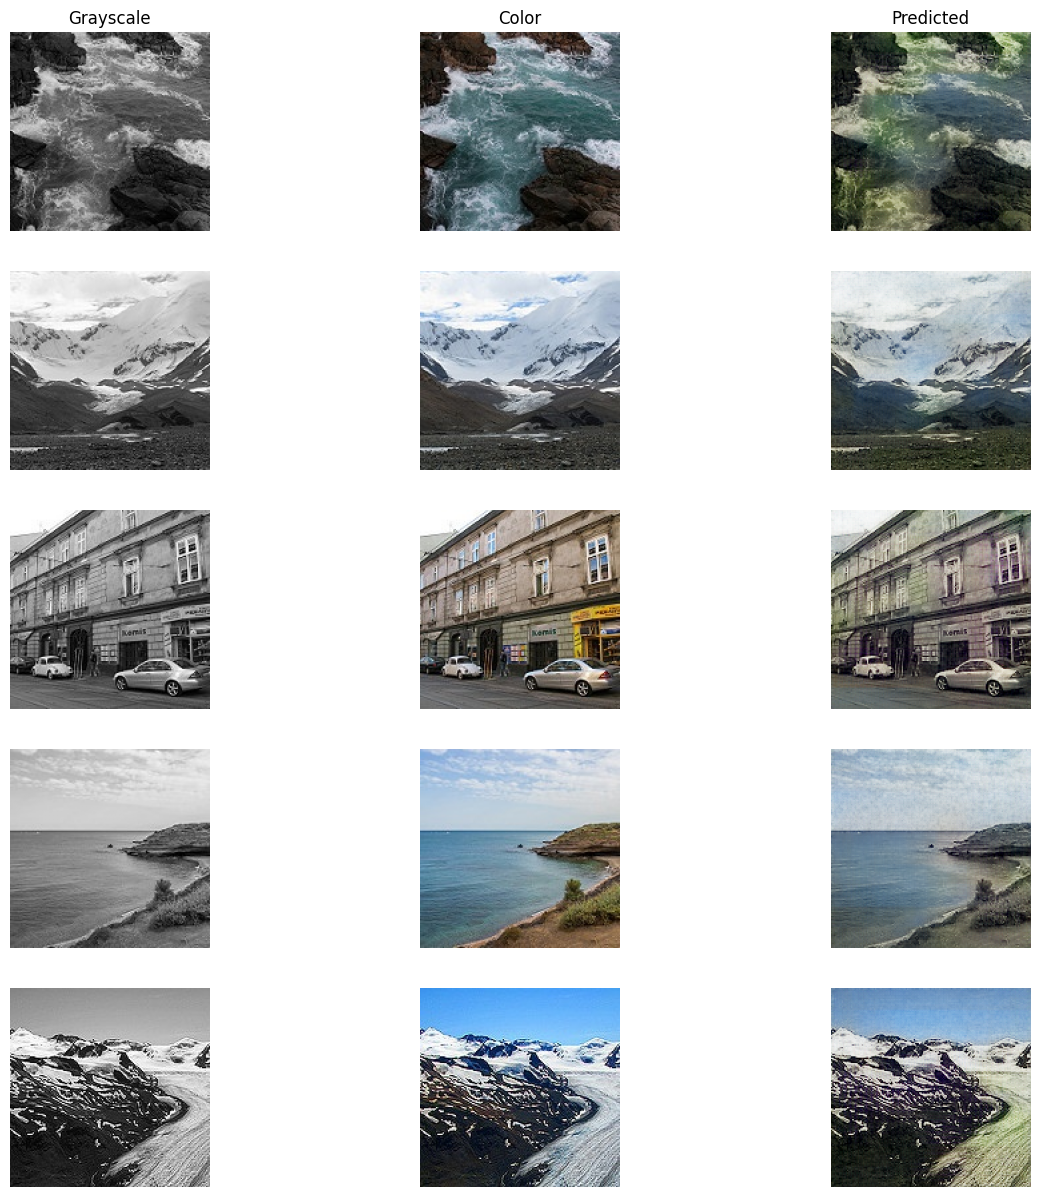

In [ ]:
show_predictions(color_img.detach().cpu(), gray_img.detach().cpu(), prediction.detach().cpu())

In [ ]:
#### using resnet

In [ ]:
import os
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.io import read_image
import optuna
import matplotlib.pyplot as plt

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Dataset Class
class LandscapeDataset(Dataset):
    def __init__(self, transform=None):
        self.dataroot = '/content/sample_data/landscape Images'
        self.images = os.listdir(f'{self.dataroot}/color')
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]

        color_img = read_image(f'{self.dataroot}/color/{img_path}').float() / 255.0
        gray_img = read_image(f'{self.dataroot}/gray/{img_path}').float() / 255.0

        if self.transform:
            color_img = self.transform(color_img)
            gray_img = self.transform(gray_img)

        return gray_img, color_img

# Data Transformations
transform = transforms.Compose([
    transforms.Resize((160, 160), antialias=True),
])

# Load Dataset
dataset = LandscapeDataset(transform=transform)

# Split dataset (Fix: Ensure total matches dataset length)
train_size = math.floor(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])

# Loaders
BATCH_SIZE = 16
trainloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

# Autoencoder Model with Batch Normalization
class ColorAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, 3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Ensure model is on the correct device
def move_to_device(model, device):
    return model.to(device)

# Training Function
def train_model(model, train_loader, criterion, optimizer, epochs=5):
    model.train()
    model.to(device)  # Ensure model is on the same device as the data
    train_losses = []

    for epoch in range(epochs):
        epoch_loss = 0
        for gray, color in train_loader:
            gray, color = gray.to(device), color.to(device)  # Ensure data is on the same device as the model

            optimizer.zero_grad()
            outputs = model(gray)
            loss = criterion(outputs, color)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

    return train_losses

# Optuna Hyperparameter Tuning
def objective(trial):
    model = ColorAutoEncoder().to(device)  # Move model to the correct device
    criterion = nn.MSELoss()
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_loss = train_model(model, trainloader, criterion, optimizer, epochs=5)
    return train_loss[-1]

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)
best_lr = study.best_params['lr']
print(f"Best Learning Rate: {best_lr}")

# Final Training with Best Learning Rate
model = ColorAutoEncoder().to(device)  # Ensure model is on the correct device
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=best_lr)
train_losses = train_model(model, trainloader, criterion, optimizer, epochs=10)

# Plot Training Loss
plt.plot(train_losses, label="Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss Curve")
plt.show()


ModuleNotFoundError: No module named 'optuna'